<a href="https://colab.research.google.com/github/tanoManzo/mimic_trajectories/blob/dev/MIMIC_TRAJECTORY_embeddings_03_collect_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection, Embeddings and Attitude

In [83]:
! pip install transformers -q

In [84]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification

load nursing notes subject-caregiver-chartdate

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
notes_path = "/content/drive/MyDrive/NIH/Data/"
notes_name = "NOTES_NURSING_TRAJECTORIES_01.csv"
df_notes = pd.read_csv(notes_path+notes_name)
df_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531675 entries, 0 to 531674
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ROW_ID      531675 non-null  int64 
 1   SUBJECT_ID  531675 non-null  int64 
 2   CGID        531675 non-null  int64 
 3   CHARTDATE   531675 non-null  object
 4   TEXT        531675 non-null  object
dtypes: int64(3), object(2)
memory usage: 20.3+ MB


In [87]:
patients = "PATIENTS.csv"
df_patients = pd.read_csv(notes_path+patients)
df_patients.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       46520 non-null  int64 
 1   SUBJECT_ID   46520 non-null  int64 
 2   GENDER       46520 non-null  object
 3   DOB          46520 non-null  object
 4   DOD          15759 non-null  object
 5   DOD_HOSP     9974 non-null   object
 6   DOD_SSN      13378 non-null  object
 7   EXPIRE_FLAG  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


In [88]:
ward_name = "ICUSTAYS.csv"
df_ward = pd.read_csv(notes_path+ward_name)
df_ward.info()
df_ward['FIRST_CAREUNIT'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          61532 non-null  int64  
 1   SUBJECT_ID      61532 non-null  int64  
 2   HADM_ID         61532 non-null  int64  
 3   ICUSTAY_ID      61532 non-null  int64  
 4   DBSOURCE        61532 non-null  object 
 5   FIRST_CAREUNIT  61532 non-null  object 
 6   LAST_CAREUNIT   61532 non-null  object 
 7   FIRST_WARDID    61532 non-null  int64  
 8   LAST_WARDID     61532 non-null  int64  
 9   INTIME          61532 non-null  object 
 10  OUTTIME         61522 non-null  object 
 11  LOS             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


array(['MICU', 'CCU', 'NICU', 'TSICU', 'SICU', 'CSRU'], dtype=object)

In [89]:
drg = "DRGCODES.csv"
df_drg = pd.read_csv(notes_path+drg)
df_drg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125557 entries, 0 to 125556
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ROW_ID         125557 non-null  int64  
 1   SUBJECT_ID     125557 non-null  int64  
 2   HADM_ID        125557 non-null  int64  
 3   DRG_TYPE       125557 non-null  object 
 4   DRG_CODE       125557 non-null  int64  
 5   DESCRIPTION    125494 non-null  object 
 6   DRG_SEVERITY   66634 non-null   float64
 7   DRG_MORTALITY  66634 non-null   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 7.7+ MB


## **Data Preprocessing**

analyzing words in future dataset

In [90]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


imports for counting words

In [91]:
import re
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('sentiwordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


Grab tsicu notes, merge with drg codes

In [92]:
# get new type of notes (TSICU)
df_notes_TSICU = df_notes.merge(df_ward.drop('ROW_ID', axis=1), on='SUBJECT_ID')
df_notes_TSICU = df_notes_TSICU.merge(df_patients.drop('ROW_ID', axis=1), on='SUBJECT_ID')
df_notes_TSICU = df_notes_TSICU.merge(df_drg[['HADM_ID','DRG_CODE','DESCRIPTION']], on=['HADM_ID'])
df_notes_TSICU = df_notes_TSICU[(df_notes_TSICU['FIRST_CAREUNIT'] == 'TSICU') & (df_notes_TSICU['LAST_CAREUNIT'] == 'TSICU')].drop_duplicates()
df_notes_TSICU.info()
df_notes_TSICU.head(5)
#print(df_drg[df_drg.duplicated(['HADM_ID'], keep=False)])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76081 entries, 5852 to 1502532
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          76081 non-null  int64  
 1   SUBJECT_ID      76081 non-null  int64  
 2   CGID            76081 non-null  int64  
 3   CHARTDATE       76081 non-null  object 
 4   TEXT            76081 non-null  object 
 5   HADM_ID         76081 non-null  int64  
 6   ICUSTAY_ID      76081 non-null  int64  
 7   DBSOURCE        76081 non-null  object 
 8   FIRST_CAREUNIT  76081 non-null  object 
 9   LAST_CAREUNIT   76081 non-null  object 
 10  FIRST_WARDID    76081 non-null  int64  
 11  LAST_WARDID     76081 non-null  int64  
 12  INTIME          76081 non-null  object 
 13  OUTTIME         76081 non-null  object 
 14  LOS             76081 non-null  float64
 15  GENDER          76081 non-null  object 
 16  DOB             76081 non-null  object 
 17  DOD             39241 non-

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,...,OUTTIME,LOS,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,DRG_CODE,DESCRIPTION
5852,1373553,8406,17765,2149-04-28,SOCIAL WORK NOTE:\n\nNew trauma pt on T-SICU f...,114444,239553,carevue,TSICU,TSICU,...,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,483,TRACHEOSTOMY WITH MECHANICAL VENTILATION 96+ H...
5853,1373550,8406,16140,2149-04-27,SICU NPN\nROS:\nNeuro: Neuro exam unchanged th...,114444,239553,carevue,TSICU,TSICU,...,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,483,TRACHEOSTOMY WITH MECHANICAL VENTILATION 96+ H...
5854,1373547,8406,16140,2149-04-26,"SICU NPN\nPt hemodynamicallly unstable today, ...",114444,239553,carevue,TSICU,TSICU,...,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,483,TRACHEOSTOMY WITH MECHANICAL VENTILATION 96+ H...
5855,1373567,8406,15659,2149-05-01,T/SICU NSG PROGRESS NOTE.\n0700>>[**2076**]\n\...,114444,239553,carevue,TSICU,TSICU,...,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,483,TRACHEOSTOMY WITH MECHANICAL VENTILATION 96+ H...
5856,1373633,8406,21570,2149-07-02,Nursing Progress Note.\n\nCV: The pt has been ...,114444,239553,carevue,TSICU,TSICU,...,2149-05-22 14:04:55,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,483,TRACHEOSTOMY WITH MECHANICAL VENTILATION 96+ H...


In [93]:
len(df_notes_TSICU['CGID'].unique())
deceased_TSICU = df_notes_TSICU[df_notes_TSICU['EXPIRE_FLAG'] == 1]
deceased_TSICU.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39241 entries, 5852 to 1502042
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          39241 non-null  int64  
 1   SUBJECT_ID      39241 non-null  int64  
 2   CGID            39241 non-null  int64  
 3   CHARTDATE       39241 non-null  object 
 4   TEXT            39241 non-null  object 
 5   HADM_ID         39241 non-null  int64  
 6   ICUSTAY_ID      39241 non-null  int64  
 7   DBSOURCE        39241 non-null  object 
 8   FIRST_CAREUNIT  39241 non-null  object 
 9   LAST_CAREUNIT   39241 non-null  object 
 10  FIRST_WARDID    39241 non-null  int64  
 11  LAST_WARDID     39241 non-null  int64  
 12  INTIME          39241 non-null  object 
 13  OUTTIME         39241 non-null  object 
 14  LOS             39241 non-null  float64
 15  GENDER          39241 non-null  object 
 16  DOB             39241 non-null  object 
 17  DOD             39241 non-

number of notes: min=1, max=124, mean=3.2422539866148887,  median=2.0


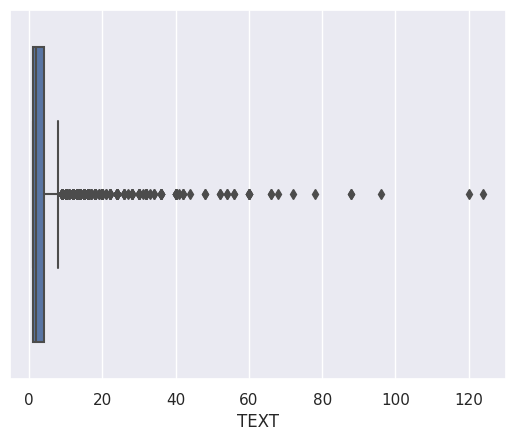

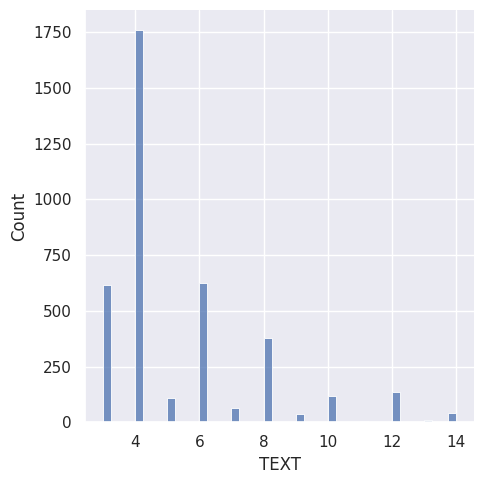

In [94]:
import seaborn as sns
sns.set()


gb_notes = deceased_TSICU.groupby(['CGID','SUBJECT_ID'])
num_notes = gb_notes['TEXT'].count()

print(f'number of notes: min={num_notes.min()}, max={num_notes.max()}, mean={num_notes.mean()},  median={num_notes.median()}')
sns.boxplot(x=num_notes)
sns.displot(num_notes[((num_notes>2) & (num_notes<15))])

In [95]:
grouping = df_notes_TSICU.groupby(['CGID','SUBJECT_ID']).size()
df_notes_TSICU['num_of_notes'] = df_notes_TSICU.set_index(['CGID','SUBJECT_ID']).index.map(grouping)
df_notes_TSICU_filtered = df_notes_TSICU[df_notes_TSICU['num_of_notes'] >= 4]
df_notes_TSICU_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46630 entries, 5852 to 1498544
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          46630 non-null  int64  
 1   SUBJECT_ID      46630 non-null  int64  
 2   CGID            46630 non-null  int64  
 3   CHARTDATE       46630 non-null  object 
 4   TEXT            46630 non-null  object 
 5   HADM_ID         46630 non-null  int64  
 6   ICUSTAY_ID      46630 non-null  int64  
 7   DBSOURCE        46630 non-null  object 
 8   FIRST_CAREUNIT  46630 non-null  object 
 9   LAST_CAREUNIT   46630 non-null  object 
 10  FIRST_WARDID    46630 non-null  int64  
 11  LAST_WARDID     46630 non-null  int64  
 12  INTIME          46630 non-null  object 
 13  OUTTIME         46630 non-null  object 
 14  LOS             46630 non-null  float64
 15  GENDER          46630 non-null  object 
 16  DOB             46630 non-null  object 
 17  DOD             24554 non-

In [96]:
df_notes_TSICU_filtered.head(10)

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,...,LOS,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,DRG_CODE,DESCRIPTION,num_of_notes
5852,1373553,8406,17765,2149-04-28,SOCIAL WORK NOTE:\n\nNew trauma pt on T-SICU f...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,483,TRACHEOSTOMY WITH MECHANICAL VENTILATION 96+ H...,11
5853,1373550,8406,16140,2149-04-27,SICU NPN\nROS:\nNeuro: Neuro exam unchanged th...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,483,TRACHEOSTOMY WITH MECHANICAL VENTILATION 96+ H...,8
5854,1373547,8406,16140,2149-04-26,"SICU NPN\nPt hemodynamicallly unstable today, ...",114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,483,TRACHEOSTOMY WITH MECHANICAL VENTILATION 96+ H...,8
5855,1373567,8406,15659,2149-05-01,T/SICU NSG PROGRESS NOTE.\n0700>>[**2076**]\n\...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,483,TRACHEOSTOMY WITH MECHANICAL VENTILATION 96+ H...,4
5856,1373633,8406,21570,2149-07-02,Nursing Progress Note.\n\nCV: The pt has been ...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,483,TRACHEOSTOMY WITH MECHANICAL VENTILATION 96+ H...,13
5858,1373595,8406,16140,2149-05-09,SICU NPN\nPt remains in the ICU s/p MVC on [**...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,483,TRACHEOSTOMY WITH MECHANICAL VENTILATION 96+ H...,8
5859,1373584,8406,16140,2149-05-06,SICU NPN\nROS:\nNeuro: Pt opens eyes inconsist...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,483,TRACHEOSTOMY WITH MECHANICAL VENTILATION 96+ H...,8
5860,1373638,8406,21570,2149-07-04,PMICU Nursing Progress Note 7p-7a\nEvents\n\n ...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,483,TRACHEOSTOMY WITH MECHANICAL VENTILATION 96+ H...,13
5861,1373604,8406,18078,2149-05-13,TRAUMA ICU NURSING PROGRESS NOTE\n\nREVIEW OF ...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,483,TRACHEOSTOMY WITH MECHANICAL VENTILATION 96+ H...,10
5862,1373560,8406,16140,2149-04-30,SICU NPN\nPt remains critically ill s/p MVC\n\...,114444,239553,carevue,TSICU,TSICU,...,26.6668,F,2117-06-28 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,2149-09-07 00:00:00,1,483,TRACHEOSTOMY WITH MECHANICAL VENTILATION 96+ H...,8


number of notes: min=2, max=4626, mean=78.04194630872483,  median=19.0


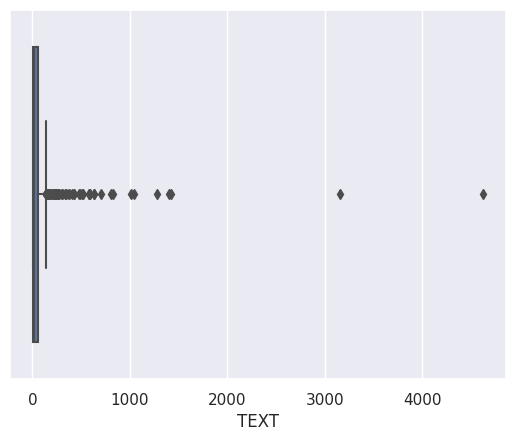

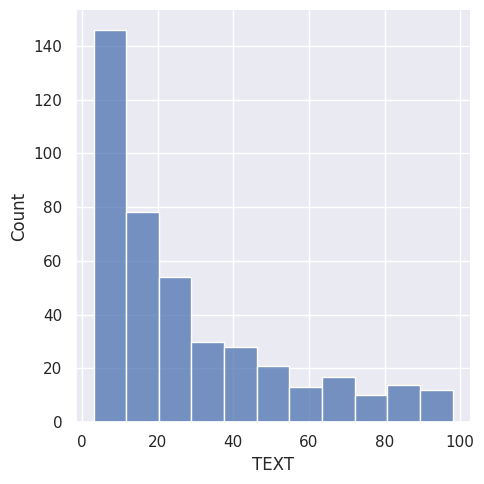

In [97]:
gb_notes = df_notes_TSICU_filtered.groupby(['DRG_CODE','DESCRIPTION'])
num_notes = gb_notes['TEXT'].count()

print(f'number of notes: min={num_notes.min()}, max={num_notes.max()}, mean={num_notes.mean()},  median={num_notes.median()}')
sns.boxplot(x=num_notes)
sns.displot(num_notes[((num_notes>2) & (num_notes<100))])

In [98]:
drg_grouping = df_notes_TSICU_filtered.groupby(['DRG_CODE','DESCRIPTION']).size()
df_notes_TSICU_filtered['num_of_conditions'] = df_notes_TSICU_filtered.set_index(['DRG_CODE','DESCRIPTION']).index.map(drg_grouping)
df_notes_TSICU_filtered = df_notes_TSICU_filtered[(df_notes_TSICU_filtered['num_of_conditions'] >= 15) & (df_notes_TSICU_filtered['num_of_conditions'] <= 1000)]
#df_notes_TSICU_filtered = df_notes_TSICU_filtered[(df_notes_TSICU_filtered['num_of_conditions'] >= 15) & (df_notes_TSICU_filtered['num_of_conditions'] <= 100)]
df_notes_TSICU_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31190 entries, 9588 to 1498544
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             31190 non-null  int64  
 1   SUBJECT_ID         31190 non-null  int64  
 2   CGID               31190 non-null  int64  
 3   CHARTDATE          31190 non-null  object 
 4   TEXT               31190 non-null  object 
 5   HADM_ID            31190 non-null  int64  
 6   ICUSTAY_ID         31190 non-null  int64  
 7   DBSOURCE           31190 non-null  object 
 8   FIRST_CAREUNIT     31190 non-null  object 
 9   LAST_CAREUNIT      31190 non-null  object 
 10  FIRST_WARDID       31190 non-null  int64  
 11  LAST_WARDID        31190 non-null  int64  
 12  INTIME             31190 non-null  object 
 13  OUTTIME            31190 non-null  object 
 14  LOS                31190 non-null  float64
 15  GENDER             31190 non-null  object 
 16  DOB              

<ipython-input-98-038e1e973d97>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notes_TSICU_filtered['num_of_conditions'] = df_notes_TSICU_filtered.set_index(['DRG_CODE','DESCRIPTION']).index.map(drg_grouping)


In [99]:
df_notes_TSICU_dropped_cols = df_notes_TSICU_filtered.drop(['FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID','LAST_WARDID','INTIME', 'OUTTIME', 'DBSOURCE','DOB','DOD','DOD_HOSP','DOD_SSN','CHARTDATE'], axis=1)
df_notes_TSICU_dropped_cols.head(10)

,ROW_ID,SUBJECT_ID,CGID,TEXT,HADM_ID,ICUSTAY_ID,LOS,GENDER,EXPIRE_FLAG,DRG_CODE,DESCRIPTION,num_of_notes,num_of_conditions
9588,1596525,25658,18240,CCU Nursing Admission Note 1130-1900\nSee CCU ...,172975,290945,2.82,M,1,1774,Cardiac Pacemaker & Defibrillator Revision Exc...,4,41.0
9589,1596525,25658,18240,CCU Nursing Admission Note 1130-1900\nSee CCU ...,172975,290945,2.82,M,1,117,CARDIAC PACEMAKER REVISION EXCEPT DEVICE REPLA...,4,41.0
9592,1596532,25658,18240,CCU Nursing Progress Note 0700-1500\nS: winci...,172975,290945,2.82,M,1,1774,Cardiac Pacemaker & Defibrillator Revision Exc...,4,41.0
9593,1596532,25658,18240,CCU Nursing Progress Note 0700-1500\nS: winci...,172975,290945,2.82,M,1,117,CARDIAC PACEMAKER REVISION EXCEPT DEVICE REPLA...,4,41.0
9596,1596569,25658,20866,CCU Nursing MICU border progress Note 7am-7pm\...,172975,290945,2.82,M,1,1774,Cardiac Pacemaker & Defibrillator Revision Exc...,10,41.0
9597,1596569,25658,20866,CCU Nursing MICU border progress Note 7am-7pm\...,172975,290945,2.82,M,1,117,CARDIAC PACEMAKER REVISION EXCEPT DEVICE REPLA...,10,41.0
9612,1596568,25658,16057,CCU Porgress note 1900-0700\nRESP:- Remains or...,172975,290945,2.82,M,1,1774,Cardiac Pacemaker & Defibrillator Revision Exc...,4,41.0
9613,1596568,25658,16057,CCU Porgress note 1900-0700\nRESP:- Remains or...,172975,290945,2.82,M,1,117,CARDIAC PACEMAKER REVISION EXCEPT DEVICE REPLA...,4,41.0
9616,1596578,25658,20866,CCU Nursing Progress Note 7am-7pm\nS: Orally ...,172975,290945,2.82,M,1,1774,Cardiac Pacemaker & Defibrillator Revision Exc...,10,41.0
9617,1596578,25658,20866,CCU Nursing Progress Note 7am-7pm\nS: Orally ...,172975,290945,2.82,M,1,117,CARDIAC PACEMAKER REVISION EXCEPT DEVICE REPLA...,10,41.0


Inverse Document Frequency

In [100]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_notes_TSICU['TEXT'])

feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1
word_score_dict = dict(zip(feature_names, tfidf_scores))

sorted_words = sorted(word_score_dict.items(), key=lambda x: x[1], reverse=True)

top_words = sorted_words[:50]

In [101]:
print("Rank\tWord\t\t\tCount")
for rank, (word, score) in enumerate(top_words, start=1):
  print(f"{rank}\t{word.ljust(20)}\t{score}")

Rank	Word			Count
1	pt                  	6093.873452297718
2	hr                  	2283.181418535095
3	pain                	1884.1704653104784
4	remains             	1732.7571098150909
5	cont                	1664.4634772162976
6	clear               	1656.7091417740567
7	neuro               	1638.1922727755152
8	plan                	1638.1199395216502
9	today               	1619.1763844453537
10	given               	1616.600220865886
11	resp                	1610.6901235755283
12	noted               	1589.9260047936693
13	care                	1569.4829446541048
14	ni                  	1569.2185323167025
15	skin                	1563.0282437416504
16	bs                  	1536.2014121600587
17	family              	1463.8397708598718
18	intact              	1457.8158198905746
19	stable              	1446.7863915673556
20	abd                 	1426.9796433205524
21	vent                	1386.8122999108916
22	monitor             	1382.0993343173104
23	100                 	1366.579047041778
24	sec

select emotional words then filter rows that dont have a minimum number of them

In [102]:
selected_words = ['pain', 'family', 'stable', 'care', 'well', 'social', 'support', 'able', 'decreased', 'warm', 'unable', 'strong', 'intact', 'good', 'times', 'aware', 'eyes', 'tolerated', 'denies', 'tolerating', 'please', 'palpable']
print("selected_words list length: ", len(selected_words))
pattern = '|'.join(selected_words)
filtered_data = df_notes_TSICU_dropped_cols[df_notes_TSICU_dropped_cols['TEXT'].str.contains(pattern, regex=True)].copy()
#filtered_data = df_notes_TSICU[df_notes_TSICU['TEXT'].str.contains(pattern, regex=True)].copy()
filtered_data['num_search_words'] = filtered_data['TEXT'].str.count(pattern)
filtered_data = filtered_data[filtered_data['num_search_words'] >= 10]
filtered_data.info()

selected_words list length:  22
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6436 entries, 9588 to 1476318
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             6436 non-null   int64  
 1   SUBJECT_ID         6436 non-null   int64  
 2   CGID               6436 non-null   int64  
 3   TEXT               6436 non-null   object 
 4   HADM_ID            6436 non-null   int64  
 5   ICUSTAY_ID         6436 non-null   int64  
 6   LOS                6436 non-null   float64
 7   GENDER             6436 non-null   object 
 8   EXPIRE_FLAG        6436 non-null   int64  
 9   DRG_CODE           6436 non-null   int64  
 10  DESCRIPTION        6436 non-null   object 
 11  num_of_notes       6436 non-null   int64  
 12  num_of_conditions  6436 non-null   float64
 13  num_search_words   6436 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 754.2+ KB


Random selection from sample set

In [103]:
random_filtered_data = filtered_data.sample(n=1000, random_state=42)

Remove similar sentences

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

sentences = random_filtered_data['TEXT'].tolist()
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(sentences)
similarity_threshold = 0.8

similar_indices = []
for i, sentence in enumerate(sentences):  # needs to be max 1000 entries
  if any(cosine_similarity(tfidf_matrix[i], tfidf_matrix[j])[0][0] > similarity_threshold for j in range(i)):  # very slow ~10 minutes for 1000 entries, exponential complexity (more than 5 hours if 6000 entries)
    similar_indices.append(i)

In [105]:
index_labels = random_filtered_data.index[similar_indices]
random_filtered_data.drop(index_labels, inplace=True)

random_filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884 entries, 958940 to 903016
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             884 non-null    int64  
 1   SUBJECT_ID         884 non-null    int64  
 2   CGID               884 non-null    int64  
 3   TEXT               884 non-null    object 
 4   HADM_ID            884 non-null    int64  
 5   ICUSTAY_ID         884 non-null    int64  
 6   LOS                884 non-null    float64
 7   GENDER             884 non-null    object 
 8   EXPIRE_FLAG        884 non-null    int64  
 9   DRG_CODE           884 non-null    int64  
 10  DESCRIPTION        884 non-null    object 
 11  num_of_notes       884 non-null    int64  
 12  num_of_conditions  884 non-null    float64
 13  num_search_words   884 non-null    int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 103.6+ KB


Find matching conditions for both expired flags

In [121]:
random_filtered_data['EXPIRE_FLAG'] = random_filtered_data['EXPIRE_FLAG'].astype(int)
group_conditions = random_filtered_data.groupby(['DRG_CODE', 'DESCRIPTION', 'EXPIRE_FLAG'])
def balance_conditions(g1,g2,size):
  size = min(len(g1), len(g2), size)
  return g1.sample(n=size, random_state=1), g2.sample(n=size, random_state=1)

rows = []
size = 200

for drg_desc, group in group_conditions:
  drg, descr, expire = drg_desc
  if (drg, descr, 1-expire) in group_conditions.groups:
    paired_group = group_conditions.get_group((drg, descr, 1-expire))
    group_sample1, group_sample2 = balance_conditions(group, paired_group, size)
    rows.append(group_sample1)
    rows.append(group_sample2)
    size -= len(group_sample1)
  if size <= 0:
    break

balanced_data = pd.concat(rows)
balanced_data = balanced_data.drop_duplicates()

balanced_data.info()
print(balanced_data[['DRG_CODE', 'DESCRIPTION', 'EXPIRE_FLAG']])

#valid_groups = [key for key, group in group_conditions.groups.keys() if (key[0], key[1], 1 - key[2]) in group_conditions.groups]
#for key in valid_groups:
  #pass

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206 entries, 925738 to 828150
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             206 non-null    int64  
 1   SUBJECT_ID         206 non-null    int64  
 2   CGID               206 non-null    int64  
 3   TEXT               206 non-null    object 
 4   HADM_ID            206 non-null    int64  
 5   ICUSTAY_ID         206 non-null    int64  
 6   LOS                206 non-null    float64
 7   GENDER             206 non-null    object 
 8   EXPIRE_FLAG        206 non-null    int64  
 9   DRG_CODE           206 non-null    int64  
 10  DESCRIPTION        206 non-null    object 
 11  num_of_notes       206 non-null    int64  
 12  num_of_conditions  206 non-null    float64
 13  num_search_words   206 non-null    int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 24.1+ KB
         DRG_CODE                                       

Seperate deceased and living

In [122]:
deceased_patients = balanced_data[balanced_data['EXPIRE_FLAG'] == 1]
deceased_patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 525068 to 828150
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             103 non-null    int64  
 1   SUBJECT_ID         103 non-null    int64  
 2   CGID               103 non-null    int64  
 3   TEXT               103 non-null    object 
 4   HADM_ID            103 non-null    int64  
 5   ICUSTAY_ID         103 non-null    int64  
 6   LOS                103 non-null    float64
 7   GENDER             103 non-null    object 
 8   EXPIRE_FLAG        103 non-null    int64  
 9   DRG_CODE           103 non-null    int64  
 10  DESCRIPTION        103 non-null    object 
 11  num_of_notes       103 non-null    int64  
 12  num_of_conditions  103 non-null    float64
 13  num_search_words   103 non-null    int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 12.1+ KB


In [123]:
living_patients = balanced_data[balanced_data['EXPIRE_FLAG'] == 0]
living_patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 925738 to 831060
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             103 non-null    int64  
 1   SUBJECT_ID         103 non-null    int64  
 2   CGID               103 non-null    int64  
 3   TEXT               103 non-null    object 
 4   HADM_ID            103 non-null    int64  
 5   ICUSTAY_ID         103 non-null    int64  
 6   LOS                103 non-null    float64
 7   GENDER             103 non-null    object 
 8   EXPIRE_FLAG        103 non-null    int64  
 9   DRG_CODE           103 non-null    int64  
 10  DESCRIPTION        103 non-null    object 
 11  num_of_notes       103 non-null    int64  
 12  num_of_conditions  103 non-null    float64
 13  num_search_words   103 non-null    int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 12.1+ KB


Display notes

In [124]:
pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_rows', None)
print(balanced_data['TEXT'].head(200))
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')

925738     T/SICU Nursing Progress Note\nS: "Take it easy:\nO: Neuro: continues with [**Last Name (un) **] monitor with icp 0-5cm with excellent waveform.  Moving all extremities but moves L leg very little.  Follows commands.  At times responds verbally bu...
757380     TSICU Nursing Progress Note\nNeuro - Remains intubated and sedated.  Lightened Q2H for neuro exams.  Off propofol and fentanyl for ~3 hours at beginning of shift, however began to be restless and back on.  When lightened MAE's, opens eyes to voic...
1077316    T-SICU admission note [**2122**]-0700\n60yo male found down between 2 parked cars, +ETOH.  Arrived in ER with GCS 13, decreased MS [**First Name (Titles) **] [**Last Name (Titles) **], intubated.  Injuries: non-depressed R skull fx, traumatic R f...
925728     TSICU NPN 11p-7a\nS/o -\n[**Name (NI) **] pt sedated on propofol 0-30mcgs/min also receiving intermittant doses of fentanyl 25mcgs over night.  Pt opens right eye to voice, follows simple commands to raise 

In [125]:
print(balanced_data.head(200))

          ROW_ID  SUBJECT_ID   CGID  \
925738   1296910        2649  17704   
757380   1341919        6055  19087   
1077316  1301104        3018  15355   
925728   1296918        2649  18792   
502702   1443443       13871  17765   
...          ...         ...    ...   
171905   1366731        7801  19087   
831063   1657178       30750  14605   
171893   1366712        7801  14418   
1128153  1306703        3425  15355   
831060   1657179       30750  18522   

                                                      TEXT  HADM_ID  \
925738   T/SICU Nursing Progress Note\nS: "Take it easy...   197327   
757380   TSICU Nursing Progress Note\nNeuro - Remains i...   177723   
1077316  T-SICU admission note [**2122**]-0700\n60yo ma...   160704   
925728   TSICU NPN 11p-7a\nS/o -\n[**Name (NI) **] pt s...   197327   
502702   SOCIAL WORK NOTE:\n\nSpoke with pt's family to...   149004   
...                                                    ...      ...   
171905   TSICU Nursing Progress No

Save to CSV

In [126]:
# path and name of the cvs file 
PATH_TO_SAVE = "/content/drive/MyDrive/NIH/Data/"
name_file_to_save = 'NOTES_NURSING_TRAJECTORIES_TSICU_test.csv'
balanced_data.to_csv(PATH_TO_SAVE+name_file_to_save,index=False)

Tokenized words

In [111]:
#text = df_notes_TSICU['TEXT'].str.cat(sep=' ')
#words = nltk.word_tokenize(text)  # very slow

Count words in notes

In [112]:
#stopwords = nltk.corpus.stopwords.words('english')
#words = [word.lower() for word in words if word.lower() not in stopwords and re.match(r'\b\w+\b', word)]  # also slow but only kinda slow
#word_counts = Counter(words)
#most_common_words = word_counts.most_common(300)

In [113]:
#print("Rank\tWord\t\t\tCount")
#for rank, word_count in enumerate(most_common_words, start=1):
  #word, count = word_count
  #print(f"{rank}\t{word.ljust(20)}\t{count}")

Emotional words

In [114]:
#emotional_words = []
#for word_count in most_common_words:
  #word = word_count[0]
  #synsets = wn.synsets(word)
  #if synsets:
    #senti_synset = swn.senti_synset(synsets[0].name())
    #if senti_synset.pos_score() > 0.45 or senti_synset.neg_score() > 0.45:
      #emotional_words.append(word)

#emotional_words

In [115]:
#from textblob import TextBlob
#emotional_words = []
#for word_count in most_common_words:
  #word = word_count[0]
  #tb = TextBlob(word)
  #sentiment = tb.sentiment.polarity
  #if abs(sentiment) > 0.35:
    #emotional_words.append(word)

#emotional_words